# Alcohol Abuse Effects on EEG Data
## Neural Data Science Final Project

### Will Kersh​
### Dylan Cullifer​
### Isabell Cook

# Imports

In [9]:
import pandas as pd
import numpy as np
import mne
import mne.viz
from mne.viz import plot_topomap
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import copy
from scipy.signal import hilbert
import os
from tqdm import tqdm

# Path names
path_dir_train = 'eeg+database/SMNI_CMI_TRAIN/'
path_dir_test = 'eeg+database/SMNI_CMI_TEST/'

# one alcoholic patient and one control with same condition
alc_1 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
control_236 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data236.csv")

alc_1.head()

Unnamed: 0  trial number sensor position  sample num  sensor value  \
0           5             0             FP1           0        -8.921   
1           6             0             FP1           1        -8.433   
2           7             0             FP1           2        -2.574   
3           8             0             FP1           3         5.239   
4           9             0             FP1           4        11.587   

  subject identifier matching condition  channel         name      time  
0                  a             S1 obj        0  co2a0000364  0.000000  
1                  a             S1 obj        0  co2a0000364  0.003906  
2                  a             S1 obj        0  co2a0000364  0.007812  
3                  a             S1 obj        0  co2a0000364  0.011719  
4                  a             S1 obj        0  co2a0000364  0.015625

# Load data
This code enumerates over all of the training data files to load them in to our EEG_data object

In [23]:
file_names = [f for f in os.listdir('eeg+database/SMNI_CMI_TRAIN/') if f.endswith('.csv')]
EEG_data = pd.DataFrame({}) # create an empty data frame that will hold data from each file

for file_name in tqdm(file_names):
    temp_df = pd.read_csv('eeg+database/SMNI_CMI_TRAIN/' + file_name) # used to read each file into EEG_data
    EEG_data = pd.concat([EEG_data, temp_df], ignore_index=True)      # add the file data to the main data frame
    
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)                      # remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] = 'S2 nomatch' # remove comma from stimulus name

print(f"Loaded {len(file_names)} files")
print(f"Total rows: {len(EEG_data)}")
EEG_data.head()

100%|██████████| 468/468 [02:12<00:00,  3.52it/s]


Loaded 468 files
Total rows: 7667712


trial number sensor position  sample num  sensor value subject identifier  \
0             0             FP1           0        -8.921                  a   
1             0             FP1           1        -8.433                  a   
2             0             FP1           2        -2.574                  a   
3             0             FP1           3         5.239                  a   
4             0             FP1           4        11.587                  a   

  matching condition  channel         name      time  
0             S1 obj        0  co2a0000364  0.000000  
1             S1 obj        0  co2a0000364  0.003906  
2             S1 obj        0  co2a0000364  0.007812  
3             S1 obj        0  co2a0000364  0.011719  
4             S1 obj        0  co2a0000364  0.015625

In [11]:
control_236.head()

Unnamed: 0  trial number sensor position  sample num  sensor value  \
0           5             0             FP1           0         3.082   
1           6             0             FP1           1         2.594   
2           7             0             FP1           2         2.106   
3           8             0             FP1           3         2.106   
4           9             0             FP1           4         3.571   

  subject identifier matching condition  channel         name      time  
0                  c             S1 obj        0  co2c0000337  0.000000  
1                  c             S1 obj        0  co2c0000337  0.003906  
2                  c             S1 obj        0  co2c0000337  0.007812  
3                  c             S1 obj        0  co2c0000337  0.011719  
4                  c             S1 obj        0  co2c0000337  0.015625

### Some Pre-processing

Creating RawArray with float64 data, n_channels=61, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 32769 samples (128.004 s)



C:\Users\isabe\AppData\Local\Temp\ipykernel_23344\1996821262.py:30: RuntimeWarning: filter_length (32769) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  mne_data.filter(l_freq=1.0, h_freq=50.0, filter_length='128s')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


c:\Users\isabe\Documents\CS 5723 _ NDS\NDS_Project\.venv\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


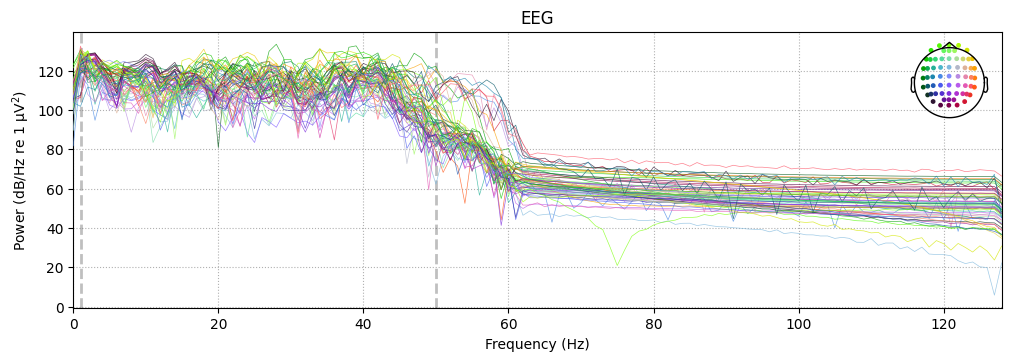

In [24]:

def csv_to_eeg_data(csv_file):
    data = pd.read_csv(csv_file)
    # Remove the positions that don't conform to the international 10-20 system.
    data = data.drop(data[data["sensor position"].isin(["X", "Y", "nd"])].index)

    # sensor placement names error out unless you fix them
    data["sensor position"] = data["sensor position"].replace({'FP1': 'Fp1', 'FP2': 'Fp2',
                                                               'FZ': 'Fz', 'CZ': 'Cz',
                                                               'PZ': 'Pz', 'FPZ': 'Fpz',
                                                               'AFZ': 'AFz', 'FCZ': 'FCz',
                                                               'POZ': 'POz', 'OZ': 'Oz',
                                                               'CPZ': 'CPz'})

    # get pos names
    sensor_pos = list(data["sensor position"].unique())
    # extract only needed eeg data
    subset = data[["channel", "sensor value", "sample num"]]
    # flip into channels x time 
    formatted = subset.pivot(index="channel", columns="sample num", values="sensor value").sort_index(axis=1)
    new_data = formatted.to_numpy()

    # convert to mne data and set channels
    channels_sfreq = mne.create_info(ch_names=sensor_pos, sfreq=256, ch_types="eeg")
    mne_data = mne.io.RawArray(new_data, channels_sfreq)

    mne_data.set_montage(mne.channels.make_standard_montage('standard_1020'))
    
    # Apply 1-50 Hz band-pass filter with shorter filter length to avoid distortion
    # Use filter length of ~0.5 seconds (128 samples) which is shorter than signal length
    mne_data.filter(l_freq=1.0, h_freq=50.0, filter_length='128s')

    return mne_data

alc_test = csv_to_eeg_data("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
alc_test.plot_psd()

# Load in all CSV Train and Test data into MNE Object and preprocess
Input from Dylan, Will, and Isabell

metadata: \
    &emsp;`trail`\
    &emsp;`group`: \
        &emsp;&emsp;`a` for alcohol\
        &emsp;&emsp;`c` for control\
    &emsp;`condition`: \
        &emsp;&emsp;'S1 obj'\
        &emsp;&emsp;'S2 match' \
        &emsp;&emsp;'S2 nomatch'\
    &emsp;`name`: subject's name

In [13]:
"""
    Read in all csvs in a directory and put them into mne.EpochsArray
    
    Input: 
        dir_path: directory path to where csv files are stored
        (Optional) sfreq: sample frequency
    Output:
        mne.EpochArray
"""
def read_csv_epoch(dir_path, sfreq=256.0):
    file_names = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
    # Define variables to use to create MNE
    datas_2d = []
    metas = []
    ch_names = None
    for f in tqdm(file_names):
        temp_df = pd.read_csv(dir_path + f)
        
        # Setup mne Matrix (channel, time)
        ## make key for this sample = time (time is the unique value)
        temp_df_time = temp_df.pivot(index='time', columns='sensor position', values='sensor value')
        ## convert to 2D numpy (time, channel)
        temp_2d = temp_df_time.to_numpy()
        ## Transpose to (channel, time)
        temp_2d = temp_2d.T
        
        # Save metadata from CSV into meta
        meta = {
            "trial": int(temp_df["trial number"].iloc[0]),
            "group": str(temp_df["subject identifier"].iloc[0]),   # 'a' or 'c' for 'alcohol' or 'control'
            "condition": str(temp_df["matching condition"].iloc[0]), # 'S1 obj', 'S2 match', or 'S2 nomatch'
            "name": str(temp_df["name"].iloc[0]),
        }
        
        # Check Channel names (Should be same for all trails)
        channels = list(temp_df_time.columns)
        if ch_names is None:
            ch_names = channels
        elif ch_names != channels: 
            print(f"{dir_path}{f} has different channels and was excluded.\n\tExpected: {ch_names}\n\tGot: {channels}")
            continue
        
        # Save data to use to create mne epoch array
        datas_2d.append(temp_2d)
        metas.append(meta)
        
    # Create 3D np array (epoch, channel, time)
    datas_3d = np.stack(datas_2d, axis=0)
    
    # Build mne info 
    ## Define type of channel - dataset has some channels that are not typical in eeg
    ch_names_filtered = ["misc" if c in ["X", "Y", "nd"] else "eeg" for c in ch_names]
    ## Create mne info object
    mne_info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_names_filtered)
    ## set montage to standard_1020
    mne_info.set_montage(mne.channels.make_standard_montage('standard_1020'), match_case=False, on_missing="ignore")
    
    # Convert metadata into a dataframe 
    metas_df = pd.DataFrame(metas)
    
    # Create events from "matching condition" in the dataset
    ## Grab unique conditions - should just be 'S1 obj', 'S2 match', or 'S2 nomatch'
    conditions = sorted(metas_df["condition"].unique())
    ## Map to an integer code
    event_ids = {cond: i+1 for i, cond in enumerate(conditions)}
    ## Map epochs to events
    event_codes = metas_df["condition"].map(event_ids).to_numpy()
    # Grab number of epochs
    n_epochs = datas_3d.shape[0]
    # Create events
    events = np.c_[np.arange(n_epochs), np.zeros(n_epochs, int), event_codes]
    
    # Create EpochsArray
    epochs = mne.EpochsArray(
        data=datas_3d,
        info=mne_info,
        events=events,
        event_id=event_ids,
        tmin=0.0,
        metadata=metas_df
    )
    
    # Print some verification statements
    print(f"CSV Files Found: {len(file_names)}")
    print(f"Epochs Loaded: {len(epochs)}")
    print(f"Number of files not loaded (missing data): {len(file_names) - len(epochs)}")
    print(f"Shape of epochs: {epochs.get_data().shape}")
    print(f"Metadata length matches epoch length: {len(epochs.metadata) == len(epochs)}")
    print(f"Number of Trials found:{epochs.metadata["trial"].nunique()}")
    print(f"Number of Subjects found: {epochs.metadata["name"].nunique()}")
    print(f"Conditions found: {epochs.metadata["condition"].unique()}")
    print(f"Groups found: {epochs.metadata["group"].unique()}")
    return epochs
        
# Read in Test and Train Data
print("Loading in Train Data")
epochs_train = read_csv_epoch(path_dir_train)
print("\nLoading in Test Data")
epochs_test = read_csv_epoch(path_dir_test)

# Merge the two via their metadata
## Concatenate teh epochs
epochs_merged = mne.concatenate_epochs([epochs_train, epochs_test])
## Drop duplicated metadata rows
unique_metadata = ~epochs_merged.metadata.duplicated()
## keep only epochs with unique data
epochs = epochs_merged[unique_metadata.to_numpy()]

# Sanity check prints
print(f"epochs_train shape: {epochs_train.get_data().shape}")
print(f"epochs_test shape: {epochs_test.get_data().shape}")
print(f"epochs shape: {epochs.get_data().shape}")

# Apply 1-50 Hz band-pass filter with shorter filter length to avoid distortion
# Use filter length of ~0.5 seconds (128 samples) which is shorter than signal length
epochs.filter(l_freq=1.0, h_freq=50.0)
        

Loading in Train Data


100%|██████████| 468/468 [00:19<00:00, 24.21it/s]

Adding metadata with 4 columns


468 matching events found
No baseline correction applied
0 projection items activated
CSV Files Found: 468
Epochs Loaded: 468
Number of files not loaded (missing data): 0
Shape of epochs: (468, 64, 256)
Metadata length matches epoch length: True
Number of Trials found:62
Number of Subjects found: 16
Conditions found: ['S1 obj' 'S2 nomatch,' 'S2 match']
Groups found: ['a' 'c']

Loading in Test Data


100%|██████████| 480/480 [00:20<00:00, 22.99it/s]


Adding metadata with 4 columns
480 matching events found
No baseline correction applied
0 projection items activated
CSV Files Found: 480
Epochs Loaded: 480
Number of files not loaded (missing data): 0
Shape of epochs: (480, 64, 256)
Metadata length matches epoch length: True
Number of Trials found:66
Number of Subjects found: 16
Conditions found: ['S1 obj' 'S2 nomatch,' 'S2 match']
Groups found: ['a' 'c']
Adding metadata with 4 columns
948 matching events found
No baseline correction applied
epochs_train shape: (468, 64, 256)
epochs_test shape: (480, 64, 256)
epochs shape: (924, 64, 256)
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz


C:\Users\isabe\AppData\Local\Temp\ipykernel_23344\3212785102.py:116: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=1.0, h_freq=50.0)


<EpochsArray | 924 events (all good), 0 – 0.996 s (baseline off), ~115.6 MiB, data loaded, with metadata,
 'S1 obj': 320
 'S2 match': 303
 'S2 nomatch,': 301>

### Separating epochs by important factors

In [14]:
"""
    Group the given mne.EpochArray into 3D dict of grouped mne.EpochArray
    
    Inputs:
        epochs: mne.EpochArray
        dim_1: name of attribute key for values stored in epochs. keys to the first dict in output
        dim_2: name of attribute key for values stored in epochs. keys to the second dict in output
        dim_2: name of attribute key for values stored in epochs. keys to the third dict in output
    Output: 2D dictionary storing mne.EpochArray
"""
def group_epochs_3D(epochs, dim_1, dim_2, dim_3):
    # Create a dict to store 3 nested dicts in:
    data = {}
    # Loop over all unique epochs of 1st dimension attribute
    for dim_1_id in tqdm(sorted(epochs.metadata[dim_1].unique())):
        # Trial is only one that is int
        dim_1_cond = f'{dim_1} == "{dim_1_id}"'
        if (dim_1 == "trial"):
            dim_1_id = int(dim_1_id)
            dim_1_cond = f'{dim_1} == {dim_1_id}'
        # Create item in data for given epoch
        data[dim_1_id] = {}
        # Loop over all unique epochs of 2nd dimension attribute
        epochs_dim_1 = epochs[dim_1_cond]
        for dim_2_id in epochs_dim_1.metadata[dim_2].unique():
            # Trial is only one that is int
            dim_2_cond = f'{dim_2} == "{dim_2_id}"'
            if (dim_2 == "trial"):
                dim_2_id = int(dim_2_id)
                dim_2_cond = f'{dim_2} == {dim_2_id}'
            # Create item in data for given 2 attributes
            data[dim_1_id][dim_2_id] = {}
            # Grab all epochs with the given 2 attributes
            epochs_dim_2 = epochs[f'{dim_1_cond} and {dim_2_cond}']
            # Loop over all unique epochs of 3rd dimension attribute
            for dim_3_id in epochs_dim_2.metadata[dim_3].unique():
                # Trial is only one that is int
                dim_3_cond = f'{dim_3} == "{dim_3_id}"'
                if (dim_3 == "trial"):
                    dim_3_id = int(dim_3_id)
                    dim_3_cond = f'{dim_3} == {dim_3_id}'
                epochs_dim_3 = epochs[f'{dim_1_cond} and {dim_2_cond} and {dim_3_cond}']
                # Store the given data for the 3 attribute values
                data[dim_1_id][dim_2_id][dim_3_id] = epochs_dim_3
    return data

"""
    Group the given mne.EpochArray into 2D dict of grouped mne.EpochArray
    
    Inputs:
        epochs: mne.EpochArray
        dim_1: name of attribute key for values stored in epochs. keys to the first dict in output
        dim_2: name of attribute key for values stored in epochs. keys to the second dict in output
    Output: 2D dictionary storing mne.EpochArray
"""
def group_epochs_2D(epochs, dim_1, dim_2):
    # Create a dict to store 3 nested dicts in:
    data = {}
    # Loop over all unique epochs of 1st dimension attribute
    for dim_1_id in tqdm(sorted(epochs.metadata[dim_1].unique())):
        # Trial is only one that is int
        dim_1_cond = f'{dim_1} == "{dim_1_id}"'
        if (dim_1 == "trial"):
            dim_1_id = int(dim_1_id)
            dim_1_cond = f'{dim_1} == {dim_1_id}'
        # Create item in data for given epoch
        data[dim_1_id] = {}
        # Loop over all unique epochs of 2nd dimension attribute
        epochs_dim_1 = epochs[dim_1_cond]
        for dim_2_id in epochs_dim_1.metadata[dim_2].unique():
            # Trial is only one that is int
            dim_2_cond = f'{dim_2} == "{dim_2_id}"'
            if (dim_2 == "trial"):
                dim_2_id = int(dim_2_id)
                dim_2_cond = f'{dim_2} == {dim_2_id}'
            # Create item in data for given 2 attributes
            data[dim_1_id][dim_2_id] = {}
            # Grab all epochs with the given 2 attributes
            epochs_dim_2 = epochs[f'{dim_1_cond} and {dim_2_cond}']
            # Store the given data for the 3 attribute values
            data[dim_1_id][dim_2_id] = epochs_dim_2
    return data

# Group epochs into 3D dict subgroups trial -> condition -> group
epochs_trial_cond_group = group_epochs_3D(epochs, "trial", "condition", "group")
# Group epochs into 3D dict subgroups condition -> group -> name
epochs_cond_group_subject = group_epochs_3D(epochs, "condition", "group", "name")
# Group epochs into 2D dict subgroups condition -> group
epochs_cond_group = group_epochs_2D(epochs, "condition", "group")


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


# Format Data

## 2D dict mne.EpochArray to 2D dict mne.evoked

(epoch, channel, time) -> (avg_channel, time)

In [15]:
"""
    Convert from dict of EpochArray to dict of evoked (Average of epoch array) 
        2D Dict of (event, channel, time) to 2D Dict of (channel, time)
    
    Input: 2 Dimensional Dictionary of mne.EpochsArray
    Output: 2 Dimensional Dictionary of mne.Evoked
"""
def convert_2D_grouping(epochs):
    # Initialize new dict
    evoked_data = {}
    # Loop over all epochs
    for key, subdict in epochs.items():
        # Initialize dict for given key
        evoked_data[key] = {}
        # Loop over 2nd dimension dictionary
        for sub_key, epoch_array in subdict.items():
            evoked_data[key][sub_key] = epoch_array.average()
    return evoked_data
            
# Convert epochs_cond_group from 2D dict mne.EpochArray to 2D dict mne.evoked
avg_cond_group = convert_2D_grouping(epochs_cond_group)

## MNE 2D dict (channel, time) -> 2D dict (region, time)

In [16]:
regions = {
    'Fp': ['FP1', 'FP2', 'FPZ'],                             # Prefrontal
    'F': ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FZ', 
          'AF1', 'AF2', 'AF7', 'AF8', 'AFZ'],                # Frontal
    'T': ['T7', 'T8', 'FT7', 'FT8', 'TP7', 'TP8'],           # Temporal
    'C': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CZ', 
          'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ',
          'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ'],  # Central
    'P': ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PZ',
          'PO1', 'PO2', 'PO7', 'PO8', 'POZ'],                # Parietal
    'O': ['O1', 'O2', 'OZ']                                  # Occipital
}

"""
    Convert from dict of evoked (Average of epoch array) in channels (62 channels) to 2D dict of evoked in regions
            2D dict of (channel, time) to 2D dict of (region, time)
    
    Input: mne.Evoked (channel, time)
    Output: mne.EvokedArray (region, time)
"""
def convert_chan_to_region(evoked):
      # Grab channel names
      ch_names = evoked.ch_names
      # Grab sample frequency
      sfreq = evoked.info['sfreq']
      # Grab time sequence
      times = evoked.times
      # Define region variable for obj data
      region_data = []
      region_names = []
      # loop over region 
      for name, channels in regions.items():
            # Select corresponding channels from evoked
            chns = mne.pick_channels(ch_names, include=channels, ordered=False)
            # Catch and skip loop if no channel exists
            if len(chns) == 0:
                  continue
            # Average the selected channels
            reg_ts = evoked.data[chns].mean(axis=0)
            # Append name and time_series data to variables
            region_data.append(reg_ts)
            region_names.append(name)

      # Create new mne info for object for region
      info = mne.create_info(ch_names=region_names, sfreq=sfreq, ch_types='eeg')
      # Create evokedArray object of regions
      region_evoked = mne.EvokedArray(region_data, info, tmin=times[0])
      return region_evoked

"""
    Convert from dict of evoked (Average of epoch array) in channels (62 channels) to 2D dict of evoked in regions
            2D dict of (channel, time) to 2D dict of (region, time)
    
    Input: 2 Dimensional Dictionary of mne.Evoked in (channel, time) shape 
    Output: 2 Dimensional Dictionary of mne.Evoked in (region, time) shape
"""
def convert_2d_avg_to_region(avg_epochs):
      region_data = {}
      for key, subdict in avg_epochs.items():
            region_data[key] = {}
            for sub_key, arr in subdict.items():
                  region_data[key][sub_key] = convert_chan_to_region(arr)
                  print(region_data[key][sub_key].data.shape)      # (n_regions, n_times)
                  print(region_data[key][sub_key].ch_names)
      return region_data
                  
reg_cond_group = convert_2d_avg_to_region(avg_cond_group)

(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']
(6, 256)
['Fp', 'F', 'T', 'C', 'P', 'O']


# Base Visualizations

In [17]:
# Define time array for all plots
times = np.arange(0,1,0.1)

## Plot Individual Evoked Groupings
Condition, group Topomap and time_series of each channel

Averaged S1 obj - a Trials for all subjects


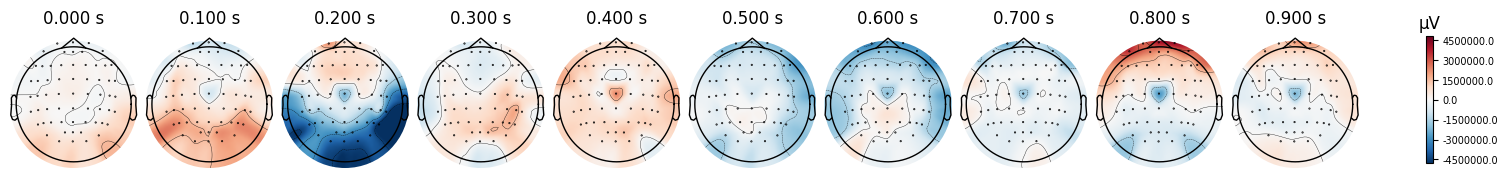

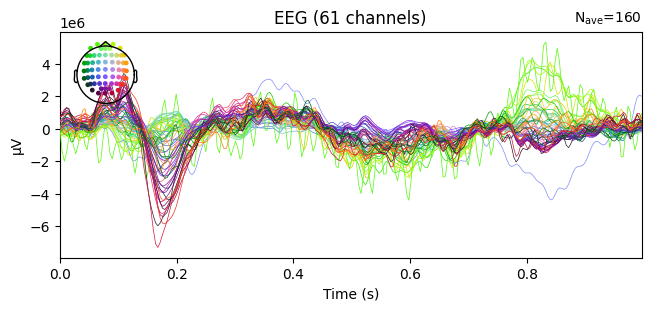

Averaged S1 obj - c Trials for all subjects


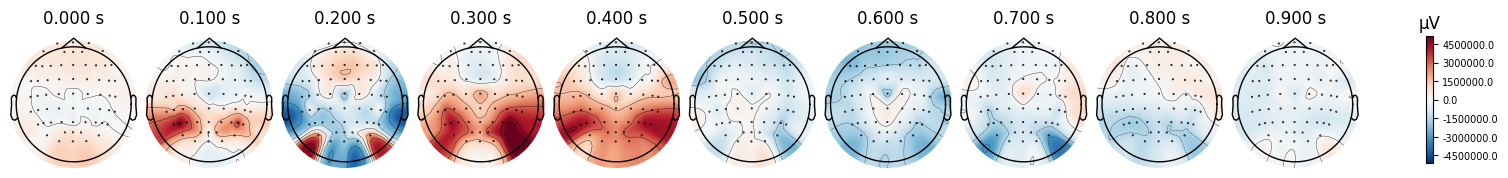

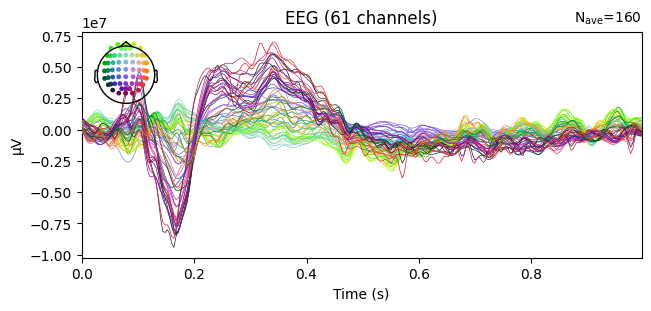

Averaged S2 match - a Trials for all subjects


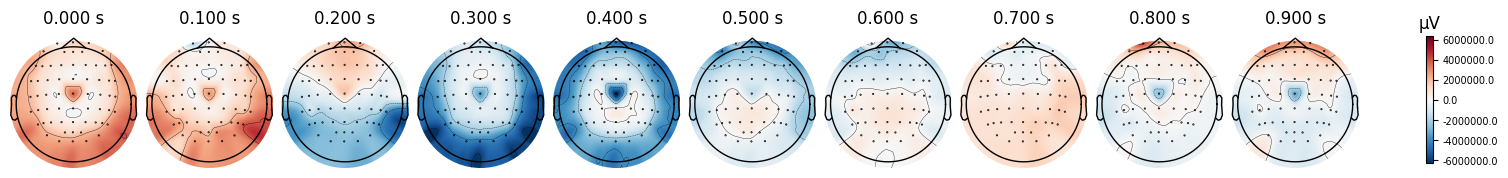

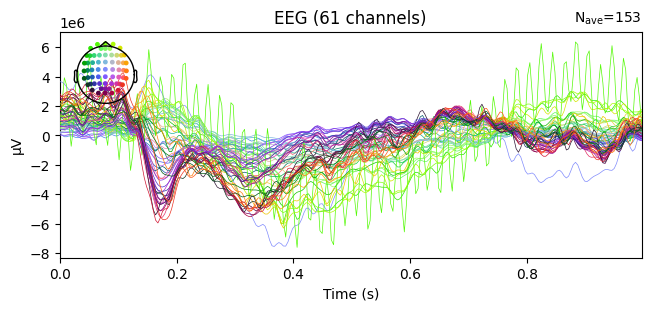

Averaged S2 match - c Trials for all subjects


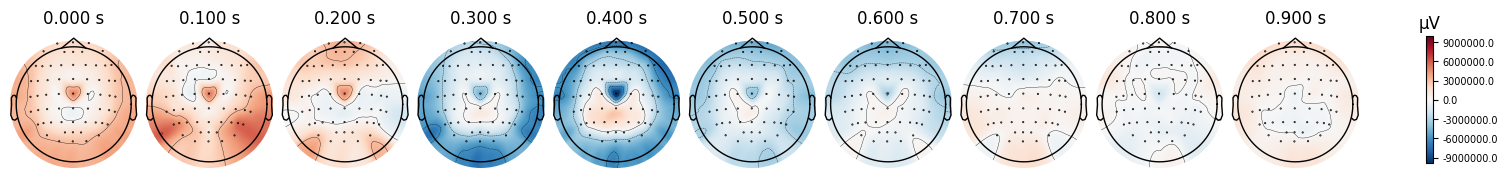

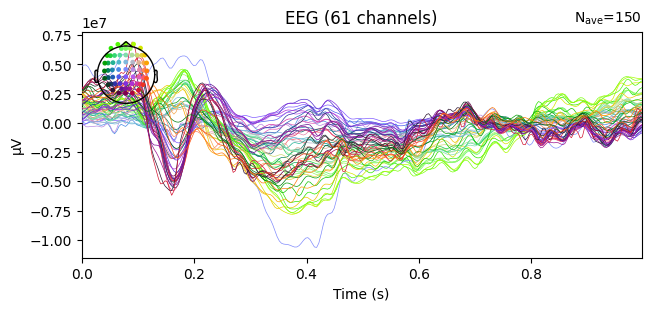

Averaged S2 nomatch, - a Trials for all subjects


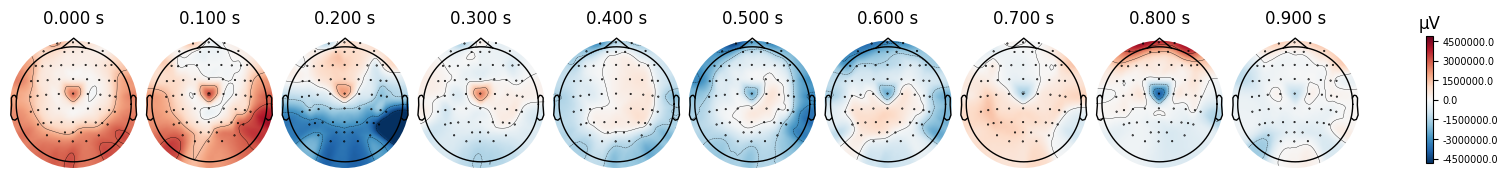

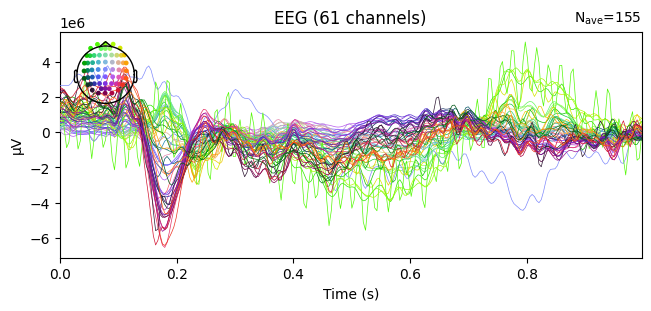

Averaged S2 nomatch, - c Trials for all subjects


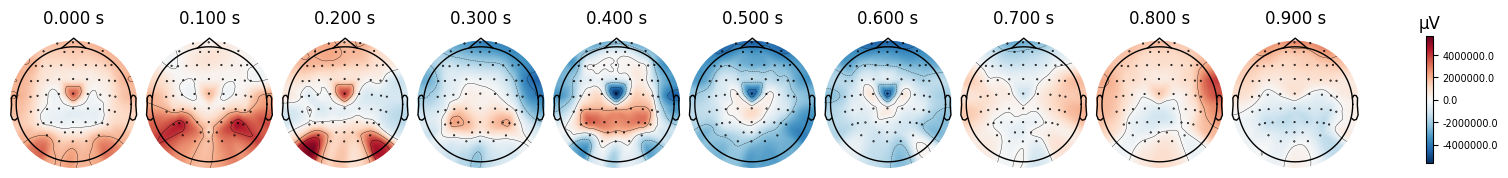

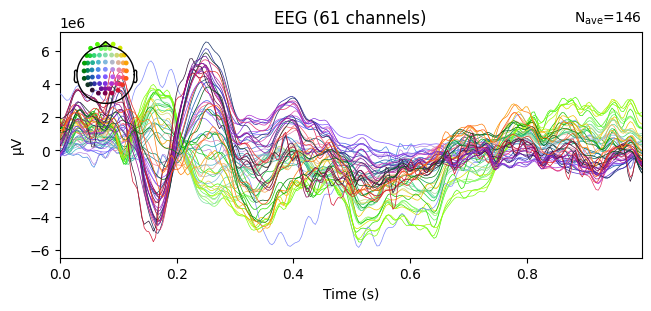

In [ ]:
# Loop over outer dict
for key, evoked_objs in avg_cond_group.items():
    # Loop over inner dict
    for sub_key, evoked in evoked_objs.items():
        print(f"Averaged {key} - {sub_key} Trials for all subjects")
        # Plot topomap
        evoked.plot_topomap(times,ch_type='eeg')
        # Plot time series data per channel
        evoked.plot()

## Plot Comparing Conditions

### Evoked GFP Time_Series

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


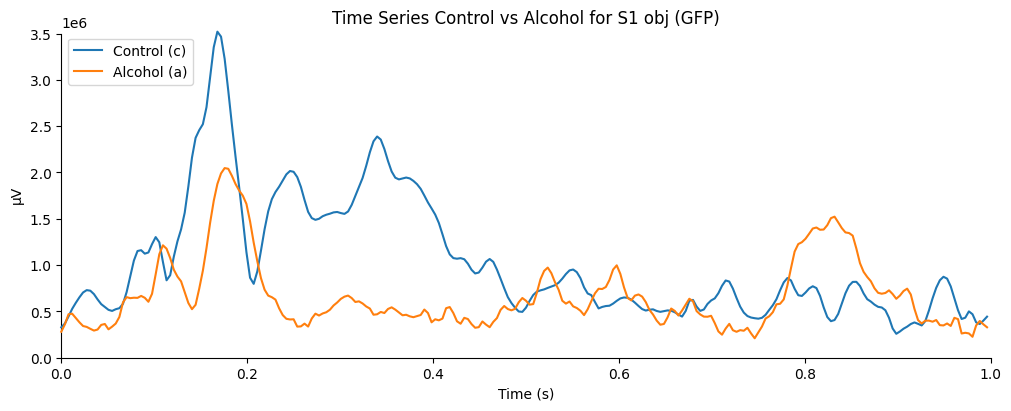

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


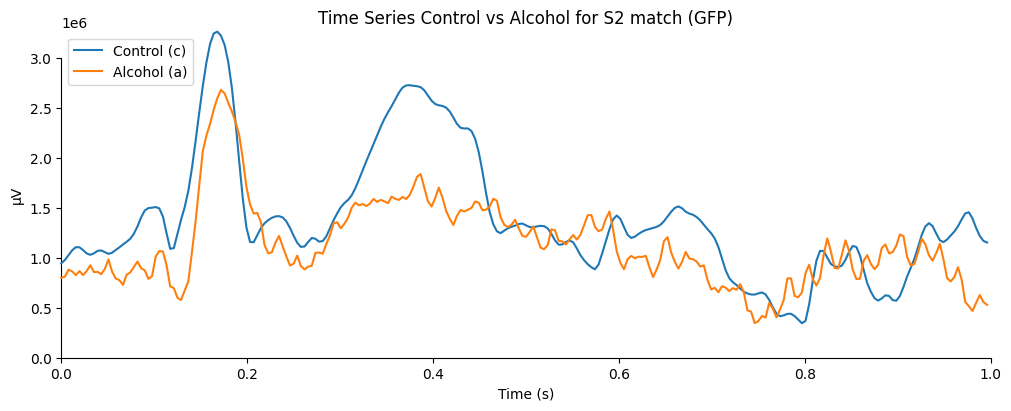

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


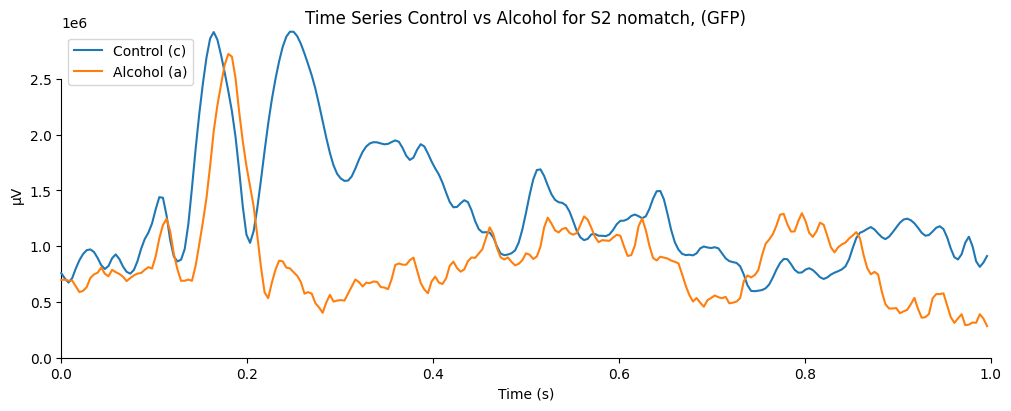

In [19]:
# Loop over outer dict
for key, evoked_objs in avg_cond_group.items():
    # Generate time_series comparison plot compare control vs alcohol
    fig = mne.viz.plot_compare_evokeds({ "Control (c)": evoked_objs["c"], "Alcohol (a)": evoked_objs["a"]}, show=False, title=f"Time Series Control vs Alcohol for {key}")
    # Resize plot
    fig[0].set_size_inches(10,4)
    # Show plot
    plt.show()

### Evoked Topomap Differences

Predicting damage so we want something in control not in alcohol
Topomap difference of S1 obj control - alcoholic averages


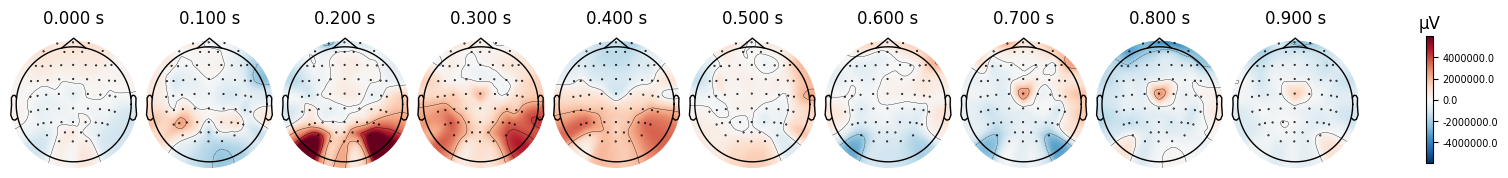

Topomap difference of S2 match control - alcoholic averages


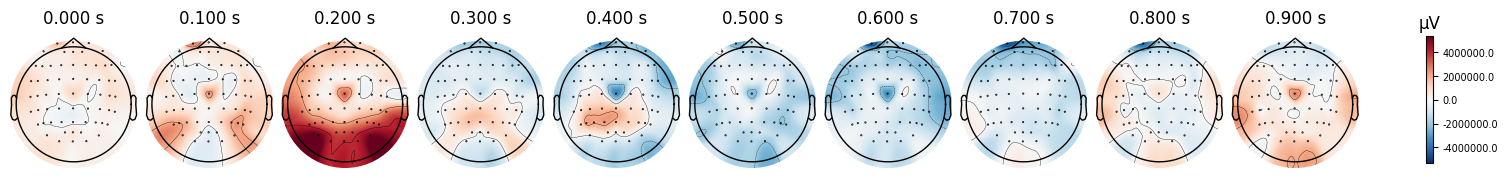

Topomap difference of S2 nomatch, control - alcoholic averages


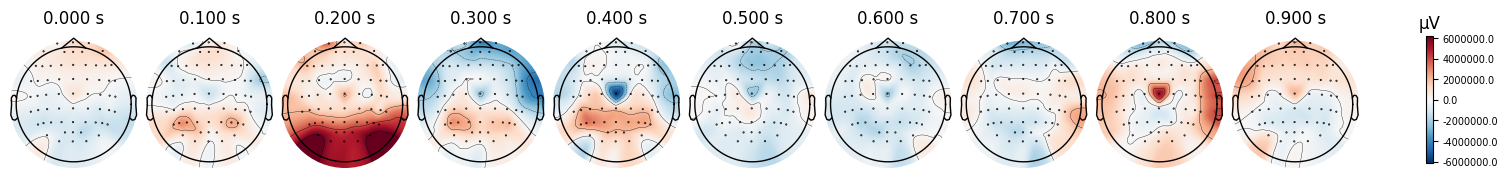

In [21]:
print("Predicting damage so we want something in control not in alcohol")
# Loop over outer dict
for key, evoked_objs in avg_cond_group.items():
    print(f"Topomap difference of {key} control - alcoholic averages")
    # Use mne to calculate difference (control - alcohol)
    evoked_diff = mne.combine_evoked([evoked_objs['c'], evoked_objs['a']], weights=[1, -1])
    # Plot topomap of difference
    evoked_diff.plot_topomap(times, ch_type='eeg')

### Evoked Region Differences

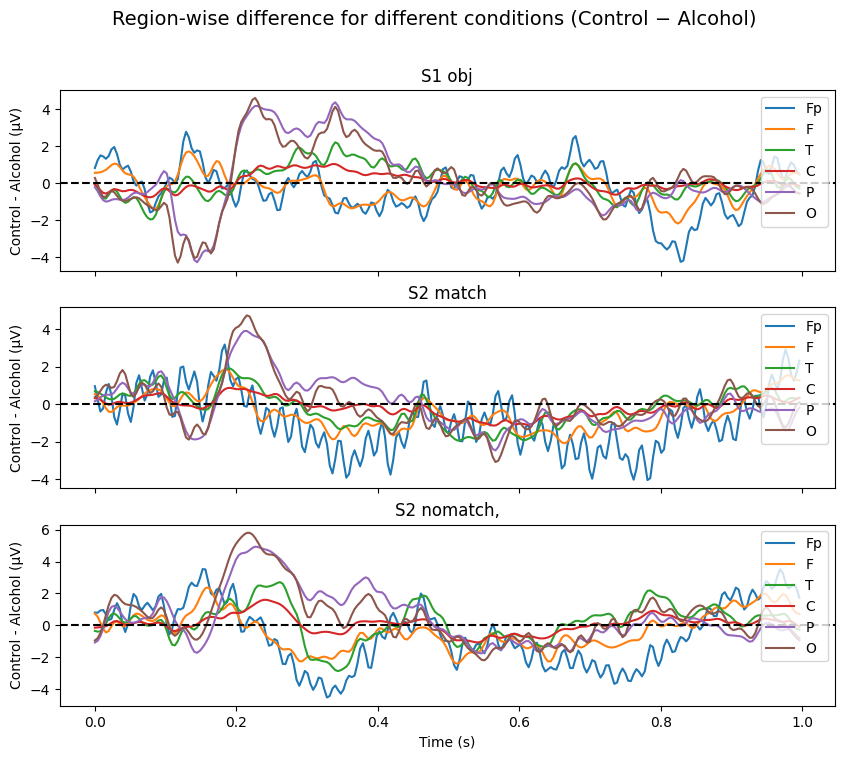

In [ ]:
# Create figure with 3 row subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
# Loop over outer dict of region evoked data
for a, (key, evoked_objs) in enumerate(reg_cond_group.items()):
    # Calculate difference between regional control - alcohol data
    diff = mne.combine_evoked([evoked_objs['c'], evoked_objs['a']], weights=[1, -1])
    # select axes
    ax = axes[a]
    # Plot difference for each region (ch_names)
    for i, reg in enumerate(diff.ch_names):
        ax.plot(diff.times, diff.data[i], label=reg)
    # Configure plot
    ## Add black dotted line at 0 for simple comparison
    ax.axhline(0, color='k', linestyle='--')
    ## label the y axis
    ax.set_ylabel("Control - Alcohol (µV)")
    ## Give subplot a title
    ax.set_title(key)
    # Add legend in same spot for all subgraphs
    ax.legend(loc="upper right")
# Label only the x axis
axes[-1].set_xlabel("Time (s)")
# Add whole figure title
fig.suptitle("Region-wise difference for different conditions (Control − Alcohol)", fontsize=14)
plt.show()